### 0. Load in Packages and Files

In [1]:
import sys
import os
import genomearray3 as ga
import numpy as np
import pysam
import Bio.SeqIO as SeqIO
from Bio.Seq import Seq
from scipy import stats
import pandas as pd
import seaborn as sns
import subprocess
#import tables
import regex
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from mpl_toolkits.axes_grid1 import host_subplot
from sklearn import linear_model
from matplotlib import ticker
from matplotlib import lines
import mpl_toolkits.axisartist as AA
import matplotlib.patches as patches
from itertools import product
import scipy.stats as sp
import dna_features_viewer as dnav
from dna_features_viewer import BiopythonTranslator
from scipy import signal
import subprocess
from statsmodels.stats.multitest import multipletests

In [2]:
## load genomes (version U00096_2)
mg1655_gbk = SeqIO.read('MG1655.gbk', 'genbank')
mg1655_gbk.description = 'MG1655'
t4_gbk =  SeqIO.read('t4_genome.gb','genbank')
t4_gbk.description = 'T4'
plasmid_gbk = SeqIO.read('pKVS45-ChrisTAC.gb','genbank')
plasmid_gbk.description = 'TAC_plasmid'

mg1655_gt = pd.read_csv('MG1655_gt.csv', index_col=0)
ec_coding_regions = mg1655_gt.loc[mg1655_gt.ncbi_type == 'CDS', ['strand','start','end']].values.astype(int)
ec_coding_mask = ga.regionstomask(ec_coding_regions, len(mg1655_gbk))

t4_gt = pd.read_csv('t4class_gt.csv',index_col=0)
t4_coding_regions = t4_gt.loc[t4_gt.locus_type == 'CDS', ['strand','start','end']].values.astype(int)
t4_coding_mask = ga.regionstomask(t4_coding_regions, len(t4_gbk))

plasmid_gt = pd.read_csv('plasmid_gene_table.csv',index_col=0)
plasmid_coding_regions = plasmid_gt.loc[plasmid_gt.locus_type == 'CDS', ['strand','start','end']].values.astype(int)
plasmid_coding_mask = ga.regionstomask(plasmid_coding_regions, len(plasmid_gbk))

/opt/anaconda3/envs/RNAenv/lib/python3.8/site-packages/Bio/GenBank/Scanner.py:1529: BiopythonParserWarning: Attempting to parse malformed locus line:
'LOCUS       pKVS45-ChrisTAC        6330 bp DNA     circular SYN 09-AUG-2022\n'
Found locus 'pKVS45-ChrisTAC' size '6330' residue_type 'DNA'
Some fields may be wrong.
  warnings.warn(


In [3]:
sequence_records_final=[mg1655_gbk,t4_gbk,plasmid_gbk]
print(len(sequence_records_final))

3


In [4]:
t4_gene_names = t4_gt.index[t4_gt.locus_type == 'CDS'].values.astype(str)
t4_all_names = t4_gt.index[:].values.astype(str)
t4_all_regions = t4_gt.loc[:, ['strand','start','end']].values.astype(int)

In [5]:
ec_gene_names = mg1655_gt.index[mg1655_gt.ncbi_type == 'CDS'].values.astype(str)
ec_all_names = mg1655_gt.index[:].values.astype(str)
ec_all_regions = mg1655_gt.loc[:, ['strand','start','end']].values.astype(int)

In [6]:
plasmid_gene_names = plasmid_gt.index[plasmid_gt.locus_type == 'CDS'].values.astype(str)
plasmid_all_names = plasmid_gt.index[:].values.astype(str)
plasmid_all_regions = plasmid_gt.loc[:, ['strand','start','end']].values.astype(int)

### 1. Load in Data

In [7]:
path_A = '/Users/chrisdoering/Documents/ChrisProject/RNAseq/231002_RIPseq/'
path_B = '/Users/chrisdoering/Documents/ChrisProject/RNAseq/231026_RIPseq/'

array_paths_T4 = [path_A+'231002_RNA_T4.npy',path_A+'231002_RIP_T4.npy',
                   path_B+'231026_RNA_T4.npy',path_B+'231026_RIP_T4.npy']
array_paths_EC = [path_A+'231002_RNA_mg1655.npy',path_A+'231002_RIP_mg1655.npy',
                   path_B+'231026_RNA_mg1655.npy',path_B+'231026_RIP_mg1655.npy']



bam_paths = [path_A+'231002_RNA.bam', path_A+'231002_RIP.bam',
            path_B+'231026_RNA.bam', path_B+'231026_RIP.bam']

sample_arrays_T4 = np.asarray([np.load(path) for path in array_paths_T4])
sample_arrays_EC = np.asarray([np.load(path) for path in array_paths_EC])

# calculate size factors from raw reads mapped to bam files
counts = []
for path in bam_paths:
    counts.append(pysam.Samfile(path, 'rb').mapped)
counts = np.asarray(counts)
CPM = counts*(10**-6)

output_T4 = sample_arrays_T4
output_EC = sample_arrays_EC

[RNA_T4_A,RIP_T4_A,RNA_T4_B,RIP_T4_B] = output_T4
[RNA_EC_A,RIP_EC_A,RNA_EC_B,RIP_EC_B] = output_EC

[RNA_CPM_A,RIP_CPM_A,RNA_CPM_B,RIP_CPM_B] = CPM.reshape(-1,1,1)
RNA_CPM_A = float(RNA_CPM_A)
RIP_CPM_A = float(RIP_CPM_A)
RNA_CPM_B = float(RNA_CPM_B)
RIP_CPM_B = float(RIP_CPM_B)

In [8]:
def RPT_calculation(gt,gbk,RIP_A,RIP_B,RNA_A,RNA_B):    
    RIP_RPT_A = []
    RNA_RPT_A = []
    RIP_RPT_B = []
    RNA_RPT_B = []

    for index, row in gt.iterrows():
        
        RIP_A_RPT = np.sum(RIP_A[row.strand][int(row.start):int(row.end)+1])/((row.end-row.start)/1000)
        RIP_RPT_A.append(RIP_A_RPT)
            
        RNA_A_RPT = np.sum(RNA_A[row.strand][int(row.start):int(row.end)+1])/((row.end-row.start)/1000)
        RNA_RPT_A.append(RNA_A_RPT)


        RIP_B_RPT = np.sum(RIP_B[row.strand][int(row.start):int(row.end)+1])/((row.end-row.start)/1000)
        RIP_RPT_B.append(RIP_B_RPT)

        RNA_B_RPT = np.sum(RNA_B[row.strand][int(row.start):int(row.end)+1])/((row.end-row.start)/1000)
        RNA_RPT_B.append(RNA_B_RPT)

    TM = gt.copy()
    TM['RIP RPT A'] = RIP_RPT_A
    TM['RNA RPT A'] = RNA_RPT_A
    TM['RIP RPT B'] = RIP_RPT_B
    TM['RNA RPT B'] = RNA_RPT_B

    return TM

In [9]:
t4_TM = RPT_calculation(t4_gt,t4_gbk,
                       RIP_T4_A,
                       RIP_T4_B,
                       RNA_T4_A,
                       RNA_T4_B)
ec_TM = RPT_calculation(mg1655_gt,mg1655_gbk,
                       RIP_EC_A,
                       RIP_EC_B,
                       RNA_EC_A,
                       RNA_EC_B)

In [10]:
t4_TM['RNA TM A'] = (t4_TM['RNA RPT A']/(np.sum(t4_TM['RNA RPT A'])+np.sum(ec_TM['RNA RPT A'])))*1000000
t4_TM['RIP TM A'] = (t4_TM['RIP RPT A']/(np.sum(t4_TM['RIP RPT A'])+np.sum(ec_TM['RIP RPT A'])))*1000000
t4_TM['RNA TM B'] = (t4_TM['RNA RPT B']/(np.sum(t4_TM['RNA RPT B'])+np.sum(ec_TM['RNA RPT B'])))*1000000
t4_TM['RIP TM B'] = (t4_TM['RIP RPT B']/(np.sum(t4_TM['RIP RPT B'])+np.sum(ec_TM['RIP RPT B'])))*1000000
t4_TM['RNA TM'] = np.mean([t4_TM['RNA TM A'],t4_TM['RNA TM B']],axis=0)
t4_TM['RIP TM'] = np.mean([t4_TM['RIP TM A'],t4_TM['RIP TM B']],axis=0)
t4_TM['Enrichment'] = np.log2(t4_TM['RIP TM']/t4_TM['RNA TM'])

In [11]:
ec_TM['RNA TM A'] = (ec_TM['RNA RPT A']/(np.sum(t4_TM['RNA RPT A'])+np.sum(ec_TM['RNA RPT A'])))*1000000
ec_TM['RIP TM A'] = (ec_TM['RIP RPT A']/(np.sum(t4_TM['RIP RPT A'])+np.sum(ec_TM['RIP RPT A'])))*1000000
ec_TM['RNA TM B'] = (ec_TM['RNA RPT B']/(np.sum(t4_TM['RNA RPT B'])+np.sum(ec_TM['RNA RPT B'])))*1000000
ec_TM['RIP TM B'] = (ec_TM['RIP RPT B']/(np.sum(t4_TM['RIP RPT B'])+np.sum(ec_TM['RIP RPT B'])))*1000000
ec_TM['RNA TM'] = np.mean([ec_TM['RNA TM A'],ec_TM['RNA TM B']],axis=0)
ec_TM['RIP TM'] = np.mean([ec_TM['RIP TM A'],ec_TM['RIP TM B']],axis=0)
ec_TM['Enrichment'] = np.log2(ec_TM['RIP TM']/ec_TM['RNA TM'])

/opt/anaconda3/envs/RNAenv/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
t4_sub = t4_TM[['locus_type','RIP TM','RIP TM A','RIP TM B','RNA TM','RNA TM A','RNA TM B','product','Enrichment']].copy()
t4_sub['genome'] = 'T4'
t4_sub

,locus_type,RIP TM,RIP TM A,RIP TM B,RNA TM,RNA TM A,RNA TM B,product,Enrichment,genome
rIIA,CDS,2754.847795,2464.136290,3045.559300,2364.758607,2049.503589,2680.013625,rIIA protector from prophage-induced early lysis,0.220280,T4
rIIA.1,CDS,3092.215336,2714.486804,3469.943867,2133.492680,1829.458400,2437.526959,rIIA.1 hypothetical protein,0.535424,T4
60,CDS,5130.696758,4834.424827,5426.968690,4072.172610,3750.320526,4394.024693,"gp60 topoisomerase II, large subunit, C-termin...",0.333356,T4
60.1,CDS,3284.696372,3040.191606,3529.201138,2700.141909,2342.098400,3058.185418,gp60.1 hypothetical protein,0.282725,T4
mobA,CDS,1757.016430,1686.492113,1827.540746,1387.914369,1261.717386,1514.111353,MobA homing endonuclease pseudogene,0.340209,T4
...,...,...,...,...,...,...,...,...,...,...
ndd.5,CDS,1380.621335,1814.075748,947.166922,2487.922169,2624.069250,2351.775087,Ndd.5 hypothetical predicted outer membrane pr...,-0.849624,T4
ndd.6,CDS,1885.006735,2313.466636,1456.546834,2496.869036,2678.757092,2314.980981,Ndd.6 conserved hypothetical predicted outer m...,-0.405550,T4
denB,CDS,1405.983568,1211.346233,1600.620903,1089.897087,923.131021,1256.663153,DenB DNA endonuclease IV,0.367388,T4
denB.1,CDS,6767.567893,6767.842740,6767.293046,7131.351646,6176.307982,8086.395309,DenB.1 hypothetical protein,-0.075538,T4


In [13]:
ec_sub = ec_TM[['ncbi_type','RIP TM','RIP TM A','RIP TM B','RNA TM','RNA TM A','RNA TM B','ncbi_name','Enrichment']].copy()
ec_sub.rename(columns={'ncbi_type':'locus_type'},inplace=True)
ec_sub.rename(columns={'ncbi_name':'product'},inplace=True)
ec_sub['genome'] = 'MG1655'
ec_sub

,locus_type,RIP TM,RIP TM A,RIP TM B,RNA TM,RNA TM A,RNA TM B,product,Enrichment,genome
thrL,CDS,16.917301,10.816290,23.018313,8.523684,6.023870,11.023498,thrL,0.988950,MG1655
thrA,CDS,3.473733,4.380390,2.567076,5.042308,6.091609,3.993006,thrA,-0.537597,MG1655
thrB,CDS,6.733894,9.120410,4.347378,8.222272,9.806094,6.638450,thrB,-0.288096,MG1655
thrC,CDS,5.359778,6.538358,4.181197,6.231319,7.067783,5.394855,thrC,-0.217365,MG1655
yaaX,CDS,1.789642,1.629149,1.950134,1.803440,2.179894,1.426986,yaaX,-0.011081,MG1655
...,...,...,...,...,...,...,...,...,...,...
creC,CDS,0.481527,0.543140,0.419914,0.492558,0.636197,0.348918,creC,-0.032675,MG1655
creD,CDS,0.272737,0.233348,0.312126,0.368067,0.389847,0.346286,creD,-0.432456,MG1655
arcA,CDS,20.214896,23.159776,17.270016,27.852346,30.160305,25.544387,arcA,-0.462380,MG1655
yjjY,CDS,17.593304,18.455618,16.730990,16.639157,19.536278,13.742036,yjjY,0.080444,MG1655


In [14]:
all_TM = pd.concat([t4_sub,ec_sub])
all_TM.reset_index(inplace=True)
all_TM['locus_type'] = all_TM['locus_type'].replace(np.nan,'other')
all_TM

,index,locus_type,RIP TM,RIP TM A,RIP TM B,RNA TM,RNA TM A,RNA TM B,product,Enrichment,genome
0,rIIA,CDS,2754.847795,2464.136290,3045.559300,2364.758607,2049.503589,2680.013625,rIIA protector from prophage-induced early lysis,0.220280,T4
1,rIIA.1,CDS,3092.215336,2714.486804,3469.943867,2133.492680,1829.458400,2437.526959,rIIA.1 hypothetical protein,0.535424,T4
2,60,CDS,5130.696758,4834.424827,5426.968690,4072.172610,3750.320526,4394.024693,"gp60 topoisomerase II, large subunit, C-termin...",0.333356,T4
3,60.1,CDS,3284.696372,3040.191606,3529.201138,2700.141909,2342.098400,3058.185418,gp60.1 hypothetical protein,0.282725,T4
4,mobA,CDS,1757.016430,1686.492113,1827.540746,1387.914369,1261.717386,1514.111353,MobA homing endonuclease pseudogene,0.340209,T4
...,...,...,...,...,...,...,...,...,...,...,...
4901,creC,CDS,0.481527,0.543140,0.419914,0.492558,0.636197,0.348918,creC,-0.032675,MG1655
4902,creD,CDS,0.272737,0.233348,0.312126,0.368067,0.389847,0.346286,creD,-0.432456,MG1655
4903,arcA,CDS,20.214896,23.159776,17.270016,27.852346,30.160305,25.544387,arcA,-0.462380,MG1655
4904,yjjY,CDS,17.593304,18.455618,16.730990,16.639157,19.536278,13.742036,yjjY,0.080444,MG1655


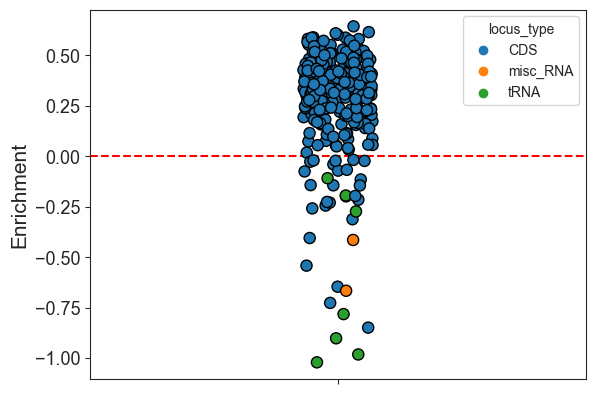

In [15]:
ax = plt.subplot(111)
sns.stripplot(data=t4_TM.reset_index(),y='Enrichment',hue='locus_type',jitter=0.07,ax=ax,size=8,edgecolor='black',linewidth=1)
plt.axhline(y=0, color='r', linestyle='--')

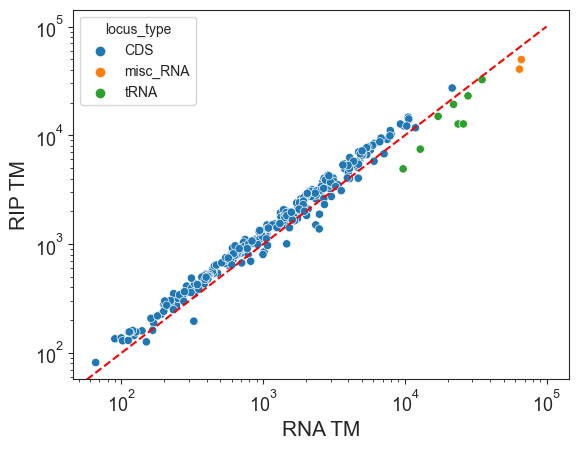

In [17]:
ax = plt.subplot(111)
sns.scatterplot(data=t4_TM,x='RNA TM',y='RIP TM',hue='locus_type')
plt.plot([0, 100000], [0, 100000], color='red', linestyle='--')
plt.xscale('log')
plt.yscale('log')

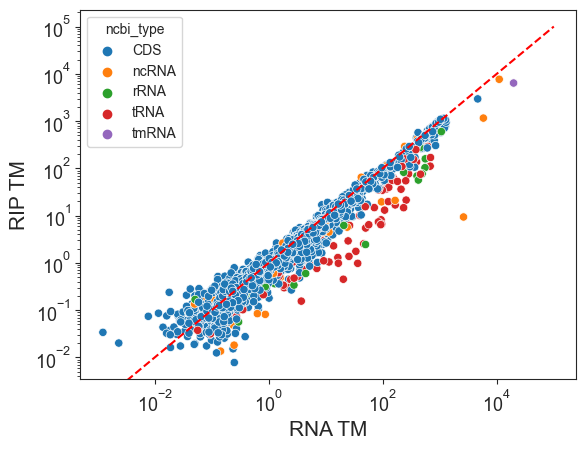

In [18]:
ax = plt.subplot(111)
sns.scatterplot(data=ec_TM,x='RNA TM',y='RIP TM',hue='ncbi_type')
plt.plot([0, 100000], [0, 100000], color='red', linestyle='--')
plt.xscale('log')
plt.yscale('log')

Text(0.5, 1.0, 'MG1655')

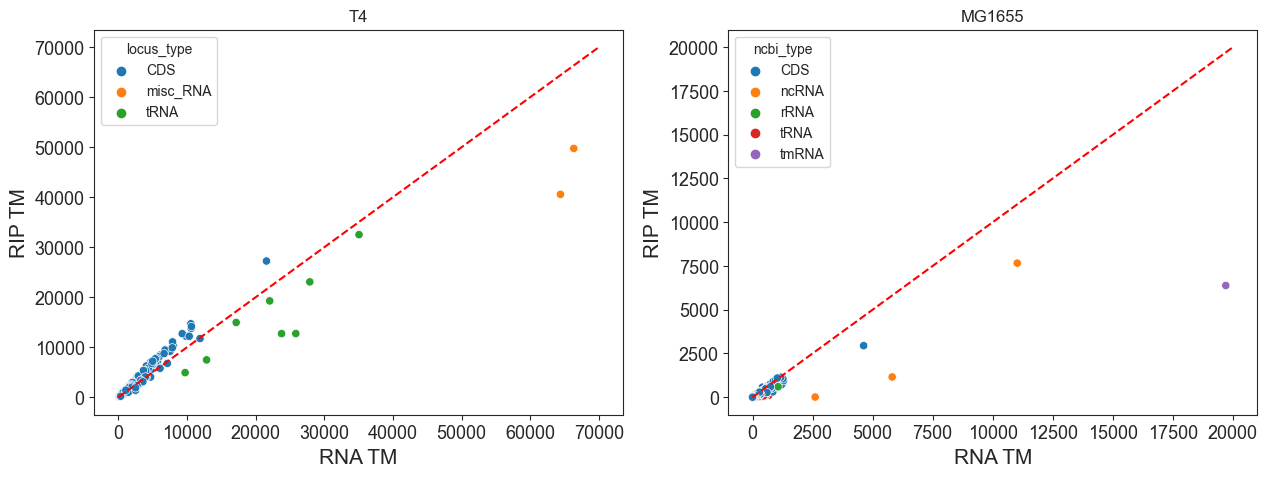

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Scatterplot 1
sns.scatterplot(data=t4_TM,x='RNA TM',y='RIP TM',hue='locus_type',ax=axes[0])
axes[0].plot([0, 70000], [0, 70000], color='red', linestyle='--')
axes[0].set_title('T4')

# Scatterplot 2
sns.scatterplot(data=ec_TM,x='RNA TM',y='RIP TM',hue='ncbi_type',ax=axes[1])
axes[1].plot([0, 20000], [0, 20000], color='red', linestyle='--')
axes[1].set_title('MG1655')

Text(0.5, 1.0, 'MG1655')

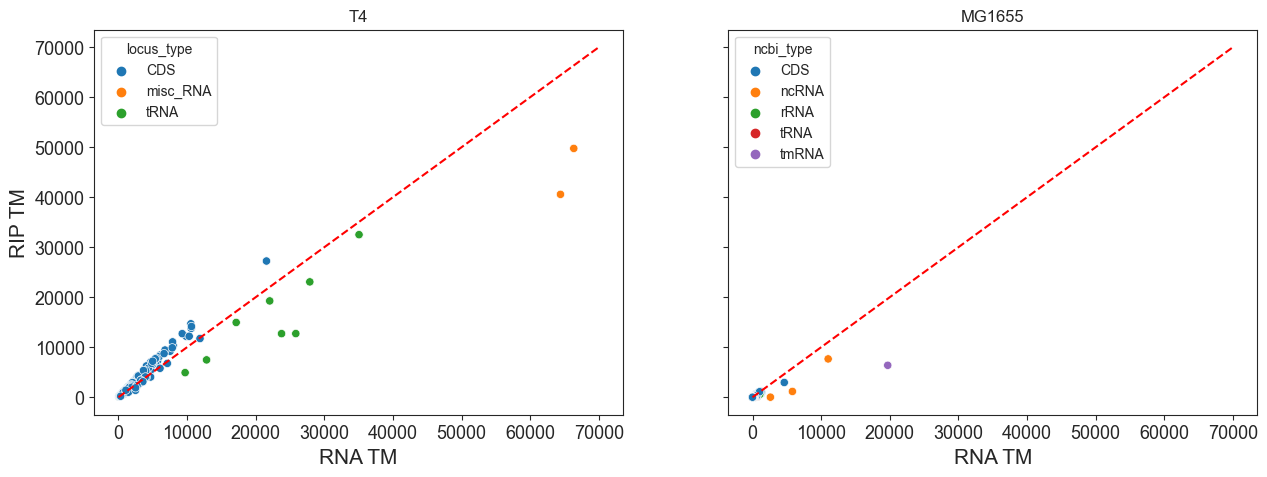

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey=True,sharex=True)

# Scatterplot 1
sns.scatterplot(data=t4_TM,x='RNA TM',y='RIP TM',hue='locus_type',ax=axes[0])
axes[0].plot([0, 70000], [0, 70000], color='red', linestyle='--')
axes[0].set_title('T4')

# Scatterplot 2
sns.scatterplot(data=ec_TM,x='RNA TM',y='RIP TM',hue='ncbi_type',ax=axes[1])
axes[1].plot([0, 70000], [0, 70000], color='red', linestyle='--')
axes[1].set_title('MG1655')


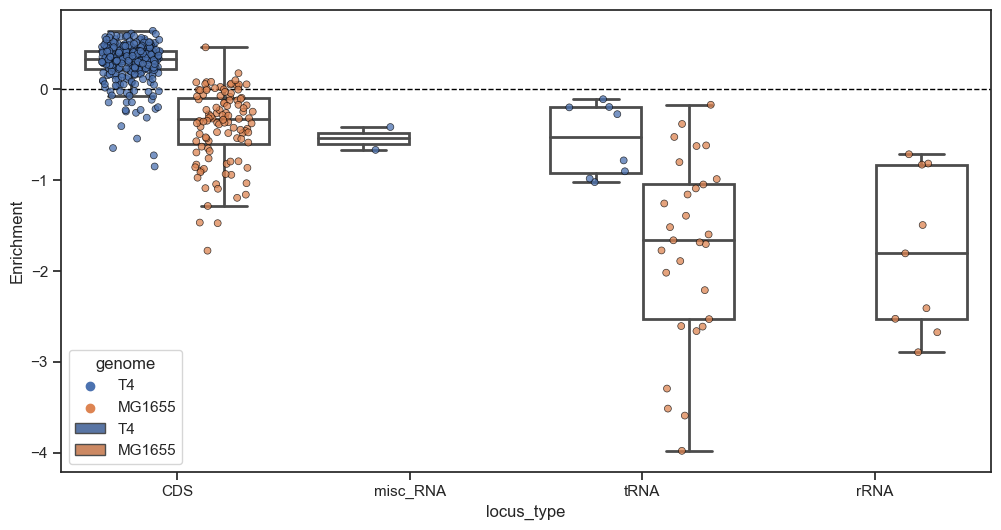

In [23]:
cutoff = np.min(t4_TM['RNA TM'])
sns.set(style='ticks', rc={'figure.figsize': (12, 6)})

sns.stripplot(data=all_TM[(all_TM['locus_type'].isin(['CDS','misc_RNA','tRNA','rRNA']))&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)],
              x='locus_type', y='Enrichment', alpha=0.75,
              hue='genome', jitter=0.25, edgecolor='black', linewidth=0.5, dodge=True)

props = {'boxprops':{'facecolor':'None'}}
sns.boxplot(data=all_TM[(all_TM['locus_type'].isin(['CDS','misc_RNA','tRNA','rRNA']))&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)],
            x='locus_type',y='Enrichment',hue='genome',dodge=True,fliersize=0,linewidth=2,**props)

plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

#plt.savefig('RIPSeq_Enrichment.svg')

In [24]:
sp.ttest_ind(t4_TM[(~np.isnan(t4_TM['Enrichment']))&(t4_TM['locus_type'] == 'CDS')]['RIP TM'],t4_TM[(~np.isnan(t4_TM['Enrichment']))&(t4_TM['locus_type'] == 'CDS')]['RNA TM'],equal_var=False)


Ttest_indResult(statistic=2.052591829551016, pvalue=0.040607279835374446)

In [25]:
#T4 CDS vs MG1655 CDS
sp.ttest_ind(all_TM[(all_TM['locus_type'] == 'CDS')&(all_TM['genome'] == 'T4')&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)]['Enrichment'],all_TM[(all_TM['locus_type'] == 'CDS')&(all_TM['genome'] == 'MG1655')&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)]['Enrichment'],equal_var=False)



Ttest_indResult(statistic=16.871192131222664, pvalue=9.91632464161747e-35)

In [26]:
#T4 CDS vs MG1655 rRNA
sp.ttest_ind(all_TM[(all_TM['locus_type'] == 'CDS')&(all_TM['genome'] == 'T4')&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)]['Enrichment'],all_TM[(all_TM['locus_type'] == 'rRNA')&(all_TM['genome'] == 'MG1655')&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)]['Enrichment'],equal_var=False)



Ttest_indResult(statistic=7.207948957810577, pvalue=8.986638658421627e-05)

In [27]:
#T4 CDS vs MG1655 tRNA
sp.ttest_ind(all_TM[(all_TM['locus_type'] == 'CDS')&(all_TM['genome'] == 'T4')&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)]['Enrichment'],all_TM[(all_TM['locus_type'] == 'tRNA')&(all_TM['genome'] == 'MG1655')&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)]['Enrichment'],equal_var=False)



Ttest_indResult(statistic=10.866914733088345, pvalue=1.3216175543623775e-11)

In [28]:
#T4 CDS vs T4 tRNA
sp.ttest_ind(all_TM[(all_TM['locus_type'] == 'CDS')&(all_TM['genome'] == 'T4')&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)]['Enrichment'],all_TM[(all_TM['locus_type'] == 'tRNA')&(all_TM['genome'] == 'T4')&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)]['Enrichment'],equal_var=False)



Ttest_indResult(statistic=6.029100765742669, pvalue=0.0004926919648818241)

In [29]:
#T4 CDS vs T4 misc_RNA
sp.ttest_ind(all_TM[(all_TM['locus_type'] == 'CDS')&(all_TM['genome'] == 'T4')&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)]['Enrichment'],all_TM[(all_TM['locus_type'] == 'misc_RNA')&(all_TM['genome'] == 'T4')&(all_TM['RNA TM A'] > cutoff)&(all_TM['RNA TM B'] > cutoff)]['Enrichment'],equal_var=False)



Ttest_indResult(statistic=6.5962802557306075, pvalue=0.0922674684501371)

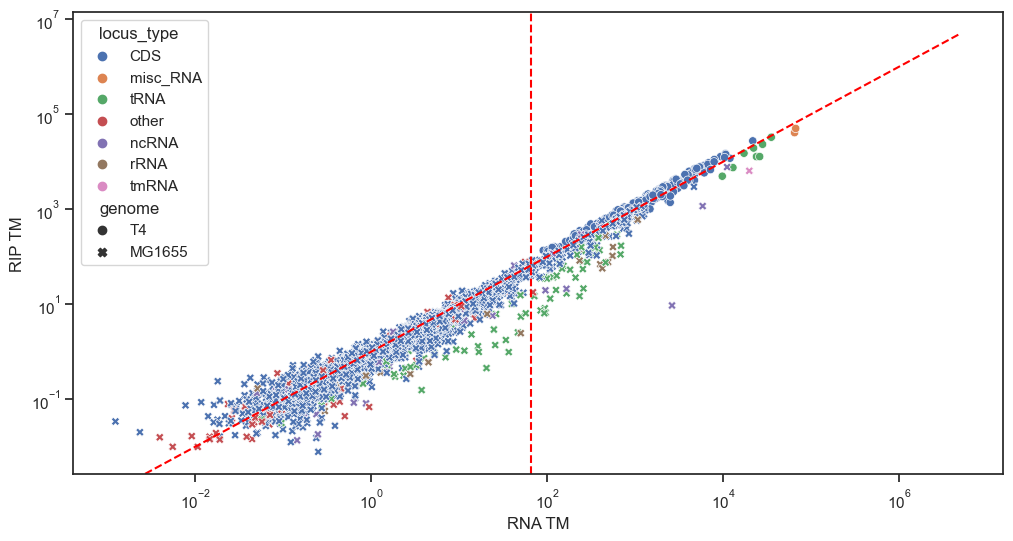

In [28]:
sns.set(style='ticks', rc={'figure.figsize': (12, 6)})
ax = plt.subplot(111)
sns.scatterplot(data=all_TM,x='RNA TM',y='RIP TM',hue='locus_type',style='genome')
plt.plot([0, 5000000], [0, 5000000], color='red', linestyle='--')
plt.axvline(x=cutoff,color = 'red',linestyle = '--')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('RIPvsRNA.png')

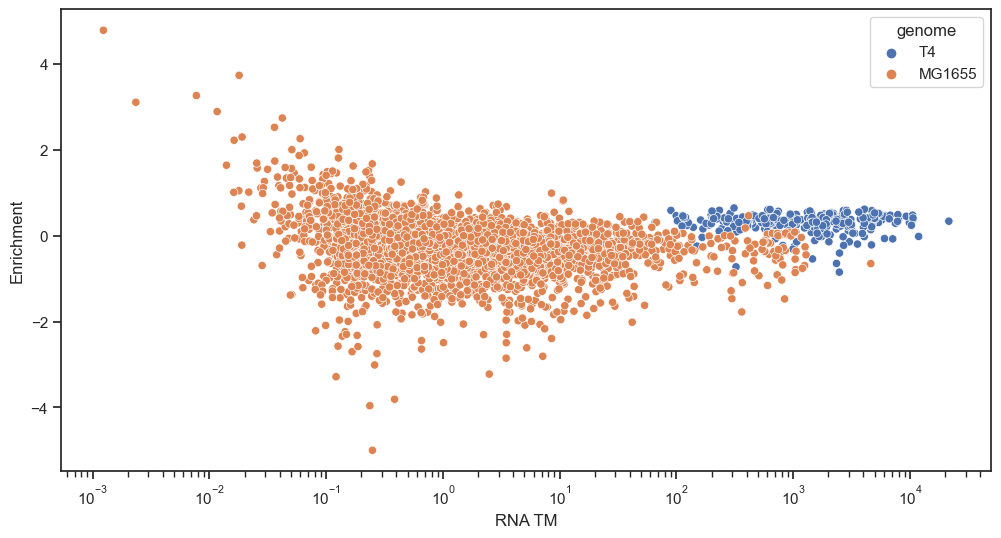

In [30]:
sns.scatterplot(data=all_TM[all_TM['locus_type'] == 'CDS'],x='RNA TM',y='Enrichment',hue='genome')
#plt.axvline(x=10,color = 'red',linestyle = '--')
plt.xscale('log')

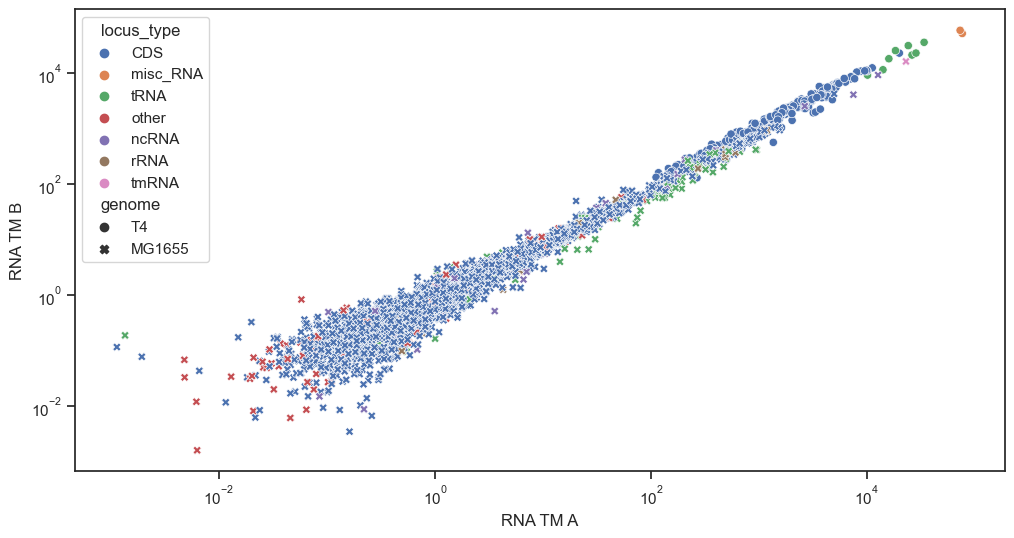

In [31]:
sns.scatterplot(data=all_TM,x='RNA TM A',y='RNA TM B',hue='locus_type',style='genome')
plt.xscale('log')
plt.yscale('log')

### GEO Submission

In [31]:
t4_TM

,strand,start,end,locus_type,product,has_intron,is_early,is_delayed_early,is_middle,is_late,...,RNA RPT A,RIP RPT B,RNA RPT B,RNA TM A,RIP TM A,RNA TM B,RIP TM B,RNA TM,RIP TM,Enrichment
rIIA,1,11,2188,CDS,rIIA protector from prophage-induced early lysis,False,False,False,True,False,...,2.020445e+07,2.116761e+07,1.644601e+07,2049.503589,2464.136290,2680.013625,3045.559300,2364.758607,2754.847795,0.220280
rIIA.1,1,2199,2402,CDS,rIIA.1 hypothetical protein,False,False,False,True,False,...,1.803520e+07,2.411722e+07,1.495799e+07,1829.458400,2714.486804,2437.526959,3469.943867,2133.492680,3092.215336,0.535424
60,1,2457,2989,CDS,"gp60 topoisomerase II, large subunit, C-termin...",False,False,False,True,False,...,3.697147e+07,3.771916e+07,2.696411e+07,3750.320526,4834.424827,4394.024693,5426.968690,4072.172610,5130.696758,0.333356
60.1,1,2970,3350,CDS,gp60.1 hypothetical protein,False,False,False,True,False,...,2.308891e+07,2.452907e+07,1.876668e+07,2342.098400,3040.191606,3058.185418,3529.201138,2700.141909,3284.696372,0.282725
mobA,1,3653,3766,CDS,MobA homing endonuclease pseudogene,False,False,False,True,False,...,1.243828e+07,1.270199e+07,9.291407e+06,1261.717386,1686.492113,1514.111353,1827.540746,1387.914369,1757.016430,0.340209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ndd.5,1,166814,166912,CDS,Ndd.5 hypothetical predicted outer membrane pr...,False,False,True,False,False,...,2.586864e+07,6.583112e+06,1.443177e+07,2624.069250,1814.075748,2351.775087,947.166922,2487.922169,1380.621335,-0.849624
ndd.6,1,166909,166995,CDS,Ndd.6 conserved hypothetical predicted outer m...,False,False,False,False,False,...,2.640777e+07,1.012347e+07,1.420598e+07,2678.757092,2313.466636,2314.980981,1456.546834,2496.869036,1885.006735,-0.405550
denB,1,167102,167659,CDS,DenB DNA endonuclease IV,False,False,False,True,False,...,9.100425e+06,1.112483e+07,7.711566e+06,923.131021,1211.346233,1256.663153,1600.620903,1089.897087,1405.983568,0.367388
denB.1,1,167742,167936,CDS,DenB.1 hypothetical protein,False,False,False,True,False,...,6.088738e+07,4.703485e+07,4.962250e+07,6176.307982,6767.842740,8086.395309,6767.293046,7131.351646,6767.567893,-0.075538


In [39]:
t4_tpm_invivo_RIPseq = t4_TM[['RNA TM A','RNA TM B','RIP TM A','RIP TM B']].copy()
t4_tpm_invivo_RIPseq['gene_name'] = t4_tpm_invivo_RIPseq.index
t4_tpm_invivo_RIPseq.rename({'RNA TM A':'cmdTAC_t4_rnaseq_rep1','RNA TM B':'cmdTAC_t4_rnaseq_rep2',
                            'RIP TM A':'cmdTAC_t4_ripseq_rep1','RIP TM B':'cmdTAC_t4_ripseq_rep2'},
                            axis='columns',inplace=True)
t4_tpm_invivo_RIPseq

,cmdTAC_t4_rnaseq_rep1,cmdTAC_t4_rnaseq_rep2,cmdTAC_t4_ripseq_rep1,cmdTAC_t4_ripseq_rep2,gene_name
rIIA,2049.503589,2680.013625,2464.136290,3045.559300,rIIA
rIIA.1,1829.458400,2437.526959,2714.486804,3469.943867,rIIA.1
60,3750.320526,4394.024693,4834.424827,5426.968690,60
60.1,2342.098400,3058.185418,3040.191606,3529.201138,60.1
mobA,1261.717386,1514.111353,1686.492113,1827.540746,mobA
...,...,...,...,...,...
ndd.5,2624.069250,2351.775087,1814.075748,947.166922,ndd.5
ndd.6,2678.757092,2314.980981,2313.466636,1456.546834,ndd.6
denB,923.131021,1256.663153,1211.346233,1600.620903,denB
denB.1,6176.307982,8086.395309,6767.842740,6767.293046,denB.1


In [40]:
t4_tpm_invivo_RIPseq.to_csv('/Volumes/CRDExternal/GEOSubmission/RIP-seq_invivo/ripseq_invivo_t4_tpm.csv',index=False)



In [38]:
ec_TM

,start,end,strand,Oname,Osize,O5,O3,ncbi_name,ncbi_type,ncbi_gop,...,RNA RPT A,RIP RPT B,RNA RPT B,RNA TM A,RIP TM A,RNA TM B,RIP TM B,RNA TM,RIP TM,Enrichment
thrL,189.0,254.0,0,thrLABC,4.0,37.0,5019.0,thrL,CDS,GO:0009088 - threonine biosynthetic process,...,59384.615385,159984.615385,67646.153846,6.023870,10.816290,11.023498,23.018313,8.523684,16.917301,0.988950
thrA,336.0,2798.0,0,thrLABC,4.0,37.0,5019.0,thrA,CDS,['GO:0009088 - threonine biosynthetic process'...,...,60052.396426,17841.998375,24503.249391,6.091609,4.380390,3.993006,2.567076,5.042308,3.473733,-0.537597
thrB,2800.0,3732.0,0,thrLABC,4.0,37.0,5019.0,thrB,CDS,['GO:0009088 - threonine biosynthetic process'],...,96670.600858,30215.665236,40737.124464,9.806094,9.120410,6.638450,4.347378,8.222272,6.733894,-0.288096
thrC,3733.0,5019.0,0,thrLABC,4.0,37.0,5019.0,thrC,CDS,['GO:0009088 - threonine biosynthetic process'],...,69675.738725,29060.653188,33105.754277,7.067783,6.538358,5.394855,4.181197,6.231319,5.359778,-0.217365
yaaX,5233.0,5529.0,0,yaaX,1.0,5233.0,5529.0,yaaX,CDS,NaN,...,21489.864865,13554.054054,8756.756757,2.179894,1.629149,1.426986,1.950134,1.803440,1.789642,-0.011081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
creC,4634718.0,4636142.0,0,creABCD,4.0,4633543.0,4637552.0,creC,CDS,['GO:0006464 - protein modification process'],...,6271.769663,2918.539326,2141.151685,0.636197,0.543140,0.348918,0.419914,0.492558,0.481527,-0.032675
creD,4636200.0,4637552.0,0,creABCD,4.0,4633543.0,4637552.0,creD,CDS,NaN,...,3843.195266,2169.378698,2125.000000,0.389847,0.233348,0.346286,0.312126,0.368067,0.272737,-0.432456
arcA,4637612.0,4638328.0,1,arcA,1.0,4638448.0,4637612.0,arcA,CDS,['GO:0006350 - transcription'],...,297326.815642,120032.122905,156754.189944,30.160305,23.159776,25.544387,17.270016,27.852346,20.214896,-0.462380
yjjY,4638424.0,4638564.0,0,yjjY,1.0,4638424.0,4638564.0,yjjY,CDS,NaN,...,192592.857143,116285.714286,84328.571429,19.536278,18.455618,13.742036,16.730990,16.639157,17.593304,0.080444


In [41]:
ec_tpm_invivo_RIPseq = ec_TM[['RNA TM A','RNA TM B','RIP TM A','RIP TM B']].copy()
ec_tpm_invivo_RIPseq['gene_name'] = ec_tpm_invivo_RIPseq.index
ec_tpm_invivo_RIPseq.rename({'RNA TM A':'cmdTAC_host_rnaseq_rep1','RNA TM B':'cmdTAC_host_rnaseq_rep2',
                            'RIP TM A':'cmdTAC_host_ripseq_rep1','RIP TM B':'cmdTAC_host_ripseq_rep2'},
                            axis='columns',inplace=True)
ec_tpm_invivo_RIPseq

,cmdTAC_host_rnaseq_rep1,cmdTAC_host_rnaseq_rep2,cmdTAC_host_ripseq_rep1,cmdTAC_host_ripseq_rep2,gene_name
thrL,6.023870,11.023498,10.816290,23.018313,thrL
thrA,6.091609,3.993006,4.380390,2.567076,thrA
thrB,9.806094,6.638450,9.120410,4.347378,thrB
thrC,7.067783,5.394855,6.538358,4.181197,thrC
yaaX,2.179894,1.426986,1.629149,1.950134,yaaX
...,...,...,...,...,...
creC,0.636197,0.348918,0.543140,0.419914,creC
creD,0.389847,0.346286,0.233348,0.312126,creD
arcA,30.160305,25.544387,23.159776,17.270016,arcA
yjjY,19.536278,13.742036,18.455618,16.730990,yjjY


In [42]:
ec_tpm_invivo_RIPseq.to_csv('/Volumes/CRDExternal/GEOSubmission/RIP-seq_invivo/ripseq_invivo_host_tpm.csv',index=False)

